# Deep Learning Models

In [1]:
import pandas as pd
import numpy as np

def load_tweets(path):
    with open(path, "rb") as f:
        import pickle
        tweets = pickle.load(f)
    return tweets

data = pd.DataFrame(data = {'tweets': load_tweets(path = "data/clean_text.pkl"),
                                 'labels': load_tweets(path = "data/Sentiment_Labels.pkl")})
data.shape

(43442, 2)

# Data Preparation

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

train, test, train_labels, test_labels = train_test_split(
   data.tweets.values, data.labels.values, train_size = 0.8, test_size = 0.2, random_state = 42)

y_train, y_test = to_categorical(train_labels, num_classes = 3), to_categorical(test_labels, num_classes = 3)

print(f"Number of training examples: {y_train.shape[0]}") 
print(f"Number of testing examples: {y_test.shape[0]}")

Number of training examples: 34753
Number of testing examples: 8689


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 140
embedding_dim = 100

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)

test_sequences = tokenizer.texts_to_sequences(test)
sequences = tokenizer.texts_to_sequences(train)

X_train = pad_sequences(sequences, maxlen = max_len)
X_test = pad_sequences(test_sequences, maxlen = max_len)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f'Vocab Size: {vocab_size}')

Vocab Size: 19355


# Baseline Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation

base_model = Sequential()

base_model.add(Embedding(vocab_size, 
                         embedding_dim, 
                         input_length = max_len))

base_model.add(Flatten())
base_model.add(Dense(3, activation='softmax'))

base_model.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 100)          1935500   
_________________________________________________________________
flatten (Flatten)            (None, 14000)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 42003     
Total params: 1,977,503
Trainable params: 1,977,503
Non-trainable params: 0
_________________________________________________________________


In [5]:
base_model.fit(X_train, y_train, epochs = 10, batch_size = 15, verbose = 1)

loss, simple_NN_accuracy = base_model.evaluate(X_test, y_test, verbose = False)

print("Testing Accuracy:  {:.4f}".format(simple_NN_accuracy))

Train on 34753 samples
Epoch 1/10
34753/34753 [==============================] - 51s 1ms/sample - loss: 0.5587 - accuracy: 0.7756
Epoch 2/10
34753/34753 [==============================] - 46s 1ms/sample - loss: 0.2728 - accuracy: 0.9121
Epoch 3/10
34753/34753 [==============================] - 48s 1ms/sample - loss: 0.1408 - accuracy: 0.9614
Epoch 4/10
34753/34753 [==============================] - 58s 2ms/sample - loss: 0.0713 - accuracy: 0.9831
Epoch 5/10
34753/34753 [==============================] - 48s 1ms/sample - loss: 0.0407 - accuracy: 0.9906
Epoch 6/10
34753/34753 [==============================] - 51s 1ms/sample - loss: 0.0262 - accuracy: 0.9938
Epoch 7/10
34753/34753 [==============================] - 58s 2ms/sample - loss: 0.0205 - accuracy: 0.9955
Epoch 8/10
34753/34753 [==============================] - 58s 2ms/sample - loss: 0.0168 - accuracy: 0.9963
Epoch 9/10
34753/34753 [==============================] - 69s 2ms/sample - loss: 0.0148 - accuracy: 0.9969
Epoch 10/10
34

# Word2Vec

In [6]:
import gensim
from gensim.models import word2vec, KeyedVectors, Word2Vec

tokens = [x.split() for x in train]

num_features = 300          
min_word_count = 10                      
num_workers = 8
window = 10 
w2v_epochs = 32

w2v_model = word2vec.Word2Vec(size = num_features, window = window, min_count = min_word_count, 
                              workers = num_workers)

w2v_model.build_vocab(tokens)

unable to import 'smart_open.gcs', disabling that module


In [7]:
w2v_model.train(tokens, total_examples = len(tokens), epochs = w2v_epochs)

(7733397, 9531680)

# PCA on Word2Vec Embeddings

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

w2v_vectors = w2v_model.wv
vocab_tmp = list(w2v_vectors.vocab)

X = w2v_model[vocab_tmp]
pca = PCA(n_components = 2).fit_transform(X)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


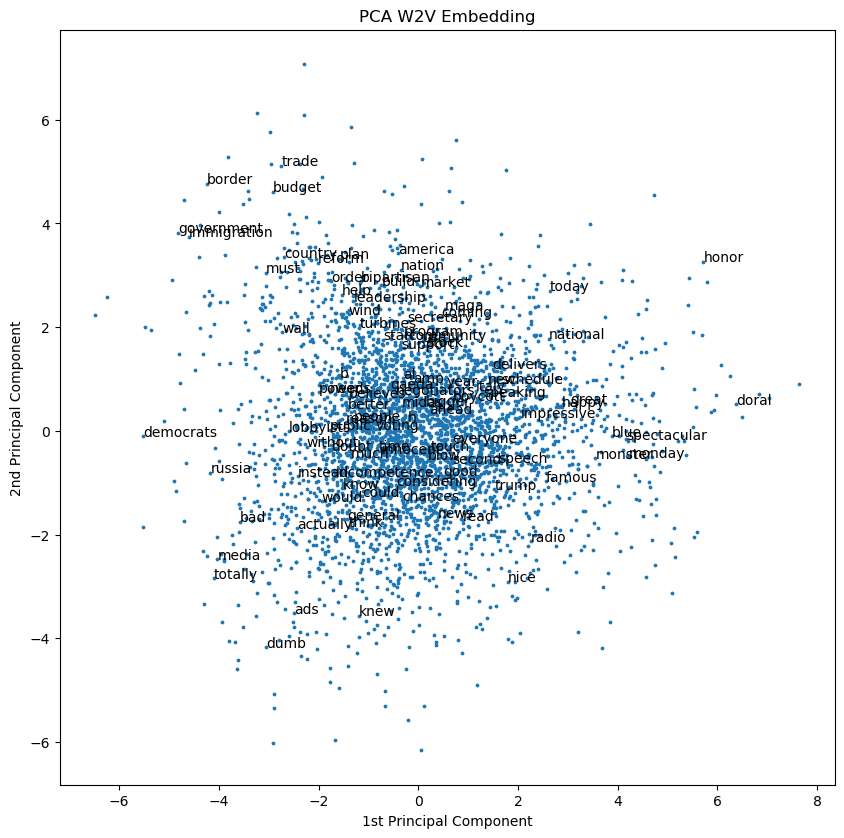

In [9]:
plt.figure(figsize = (10, 10), dpi = 100)

df = pd.concat([pd.DataFrame(pca), pd.Series(vocab_tmp)], axis = 1)
df.columns = ['x', 'y', 'word']

plt.xlabel("1st Principal Component")
plt.ylabel('2nd Principal Component')

plt.scatter(x = pca[:, 0], y = pca[:, 1], s = 3)

for i, word in enumerate(df['word'][0:100]):
    plt.annotate(word, (df['x'].iloc[i], df['y'].iloc[i]))
    
plt.title("PCA W2V Embedding")
plt.show()

In [10]:
w2v_model.most_similar('trump')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('gorgeous', 0.36849185824394226),
 ('donaldtrump', 0.3543216586112976),
 ('ya', 0.3468290865421295),
 ('exclusive', 0.33142125606536865),
 ('trumps', 0.3282260298728943),
 ('amen', 0.3277851939201355),
 ('mac', 0.3132534623146057),
 ('cute', 0.3117872476577759),
 ('hey', 0.3090977072715759),
 ('miller', 0.30780404806137085)]

In [11]:
w2v_model.most_similar('fox')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('network', 0.6050807237625122),
 ('cable', 0.5930696129798889),
 ('wallace', 0.5882166028022766),
 ('abc', 0.5522812008857727),
 ('susteren', 0.550992488861084),
 ('greta', 0.5268176794052124),
 ('cbs', 0.4882816970348358),
 ('hannity', 0.48290926218032837),
 ('radio', 0.4793538749217987),
 ('megyn', 0.4764958918094635)]

In [12]:
w2v_model.most_similar('china')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('chinese', 0.6765053868293762),
 ('manipulation', 0.5859036445617676),
 ('currency', 0.5653375387191772),
 ('tariffs', 0.5211538076400757),
 ('opec', 0.5016328692436218),
 ('products', 0.4795856475830078),
 ('markets', 0.45556360483169556),
 ('deficits', 0.45360469818115234),
 ('ally', 0.45344921946525574),
 ('oil', 0.45131218433380127)]

In [13]:
w2v_model.most_similar('mexico')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('caravans', 0.5665349960327148),
 ('southern', 0.5576746463775635),
 ('mexican', 0.5489332675933838),
 ('tariffs', 0.5447225570678711),
 ('wall', 0.525783896446228),
 ('canada', 0.5031988620758057),
 ('goods', 0.4885951280593872),
 ('pouring', 0.48728621006011963),
 ('crossing', 0.47885650396347046),
 ('tariff', 0.47392383217811584)]

In [14]:
w2v_model.most_similar('trade')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('deals', 0.5722286701202393),
 ('tariffs', 0.5443344116210938),
 ('european', 0.5324186682701111),
 ('negotiated', 0.506536602973938),
 ('products', 0.5015829801559448),
 ('goods', 0.4705379605293274),
 ('negotiate', 0.4685816764831543),
 ('negotiators', 0.46477293968200684),
 ('manipulation', 0.4620705544948578),
 ('canada', 0.46011289954185486)]

In [15]:
w2v_model.most_similar('maga')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('kag', 0.640243649482727),
 ('trumppence', 0.632021427154541),
 ('movement', 0.6139856576919556),
 ('votetrump', 0.5950288772583008),
 ('americafirst', 0.5942381620407104),
 ('mississippi', 0.5795724391937256),
 ('rncincle', 0.5751821994781494),
 ('colorado', 0.5567994117736816),
 ('maine', 0.5559406280517578),
 ('cincinnati', 0.5533363819122314)]

In [16]:
w2v_model.most_similar('dems')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('democrats', 0.7174068093299866),
 ('democrat', 0.557166337966919),
 ('overwhelming', 0.5056252479553223),
 ('swamp', 0.49510282278060913),
 ('pelosi', 0.49097245931625366),
 ('votes', 0.47662025690078735),
 ('witnesses', 0.47498777508735657),
 ('impeach', 0.4748157262802124),
 ('dem', 0.4735361337661743),
 ('senators', 0.4667736887931824)]

In [17]:
w2v_model.most_similar('clinton')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crooked', 0.6830451488494873),
 ('beating', 0.553924560546875),
 ('emails', 0.499237596988678),
 ('hrc', 0.4883459210395813),
 ('podesta', 0.4851284623146057),
 ('email', 0.47445452213287354),
 ('crookedhillary', 0.47180432081222534),
 ('mails', 0.4560152292251587),
 ('praised', 0.45037832856178284),
 ('donors', 0.4411752223968506)]

In [18]:
w2v_model.most_similar('korea')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('korean', 0.7696229219436646),
 ('dakota', 0.6806026101112366),
 ('jong', 0.6325665712356567),
 ('north', 0.6275818347930908),
 ('kim', 0.6170685291290283),
 ('un', 0.6123074293136597),
 ('carolina', 0.5890439748764038),
 ('rocket', 0.5739187598228455),
 ('moon', 0.502570390701294),
 ('south', 0.49727436900138855)]

In [19]:
w2v_model.most_similar('liberals')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('afraid', 0.5605459809303284),
 ('refreshing', 0.5077658295631409),
 ('integrity', 0.500637412071228),
 ('establishment', 0.482353150844574),
 ('conservatives', 0.46561524271965027),
 ('chances', 0.4614848792552948),
 ('nominee', 0.4558754861354828),
 ('goofy', 0.45144158601760864),
 ('proof', 0.44431591033935547),
 ('scared', 0.42628610134124756)]

In [20]:
w2v_model.most_similar('help')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('send', 0.41967442631721497),
 ('desperately', 0.40483516454696655),
 ('resources', 0.3904075622558594),
 ('save', 0.3717900216579437),
 ('removed', 0.37106263637542725),
 ('stop', 0.3561256229877472),
 ('funding', 0.35008081793785095),
 ('incapable', 0.34916937351226807),
 ('ensure', 0.34879952669143677),
 ('donate', 0.3470019996166229)]

In [21]:
w2v_model.most_similar('love')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('admire', 0.4278568625450134),
 ('inspiration', 0.4162018299102783),
 ('loved', 0.3953329920768738),
 ('ya', 0.3944278061389923),
 ('carry', 0.3822203278541565),
 ('theapprentice', 0.3765082359313965),
 ('awesome', 0.3742666244506836),
 ('proud', 0.3591617941856384),
 ('role', 0.3544189929962158),
 ('mom', 0.35190659761428833)]

In [22]:
w2v_model.most_similar('great')

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fantastic', 0.6486105918884277),
 ('incredible', 0.5330725908279419),
 ('amazing', 0.5066230893135071),
 ('wonderful', 0.4581117033958435),
 ('excellent', 0.44425511360168457),
 ('outstanding', 0.43401169776916504),
 ('awesome', 0.42056721448898315),
 ('tremendous', 0.41323551535606384),
 ('terrific', 0.4123481214046478),
 ('proud', 0.41154414415359497)]

# CNN with Trained Embeddings

In [23]:
embedding_matrix = np.zeros((vocab_size, num_features))

for word, i in word_index.items():
    if word in w2v_vectors:
        embedding_matrix[i] = w2v_vectors[word]
        
print(embedding_matrix.shape)

(19355, 300)


In [24]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_model = Sequential()

cnn_model.add(Embedding(vocab_size,
                        num_features, 
                        weights = [embedding_matrix], 
                        input_length = max_len))

cnn_model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn_model.add(MaxPooling1D(pool_size = 2))
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation = 'softmax'))
cnn_model.add(Dense(3, activation = 'softmax'))

cnn_model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          5806500   
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               560250    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 753       
Total params: 6,396,335
Trainable params: 6,396,335
Non-trainable params: 0
____________________________________________

In [25]:
cnn_model.fit(X_train, y_train, epochs = 10, batch_size = 30, verbose = 1)

loss, CNN_w2v_accuracy = cnn_model.evaluate(X_test, y_test, verbose = False)

print("Testing Accuracy:  {:.4f}".format(CNN_w2v_accuracy))

Train on 34753 samples
Epoch 1/10
34753/34753 [==============================] - 169s 5ms/sample - loss: 0.7582 - accuracy: 0.7139
Epoch 2/10
34753/34753 [==============================] - 152s 4ms/sample - loss: 0.4999 - accuracy: 0.8387
Epoch 3/10
34753/34753 [==============================] - 153s 4ms/sample - loss: 0.3614 - accuracy: 0.8939
Epoch 4/10
34753/34753 [==============================] - 217s 6ms/sample - loss: 0.2796 - accuracy: 0.9222
Epoch 5/10
34753/34753 [==============================] - 197s 6ms/sample - loss: 0.2296 - accuracy: 0.9391
Epoch 6/10
34753/34753 [==============================] - 186s 5ms/sample - loss: 0.1955 - accuracy: 0.9501
Epoch 7/10
34753/34753 [==============================] - 205s 6ms/sample - loss: 0.1694 - accuracy: 0.9571
Epoch 8/10
34753/34753 [==============================] - 182s 5ms/sample - loss: 0.1461 - accuracy: 0.9636
Epoch 9/10
34753/34753 [==============================] - 149s 4ms/sample - loss: 0.1309 - accuracy: 0.9671
Epoch

# LSTM with GloVe Pre-Trained Embedding

In [26]:
path = "/home/jovyan/Trump_Twitter_Sentiment_Analysis/data/glove.6B.100d.txt"

def create_embedding_matrix(filepath, num_features):
    
    embedding_matrix = np.zeros((vocab_size, num_features))
    
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                embedding_matrix[i] = word_index[word]
                
    return embedding_matrix

glove_embedding = create_embedding_matrix(filepath = path, num_features = embedding_dim)

In [27]:
from tensorflow.keras.layers import LSTM, Dropout, SpatialDropout1D

rnn_model = Sequential()

rnn_model.add(Embedding(vocab_size, 
                        embedding_dim, 
                        weights = [glove_embedding], 
                        input_length = max_len,
                        trainable = False))


rnn_model.add(SpatialDropout1D(0.2))
rnn_model.add(LSTM(50, dropout = 0.2, recurrent_dropout = 0.2))
rnn_model.add(Dense(3, activation='softmax'))

rnn_model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'adam', 
                  metrics = ['accuracy'])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 100)          1935500   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 140, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 1,965,853
Trainable params: 30,353
Non-trainable params: 1,935,500
_________________________________________________________________


In [28]:
rnn_model.load_weights(latest)

# trained 10 epochs in total
rnn_model.fit(X_train, y_train, epochs = 3, batch_size = 200, verbose = 1)

loss, LSTM_GloVe_accuracy = rnn_model.evaluate(X_test, y_test, verbose = False)

print("Testing Accuracy:  {:.4f}".format(LSTM_GloVe_accuracy))

Train on 34753 samples
Epoch 1/3
34753/34753 [==============================] - 137s 4ms/sample - loss: 0.6006 - accuracy: 0.7458
Epoch 2/3
34753/34753 [==============================] - 111s 3ms/sample - loss: 0.5852 - accuracy: 0.7554
Epoch 3/3
34753/34753 [==============================] - 116s 3ms/sample - loss: 0.5751 - accuracy: 0.7603
Testing Accuracy:  0.7919


# Model Result Summary

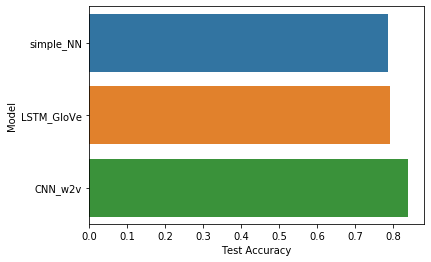

In [29]:
import seaborn as sns

models = ['simple_NN', 'CNN_w2v', 'LSTM_GloVe']

model_acc = pd.DataFrame.from_dict({
    'Model': models,
    'Test Accuracy': [eval(m + '_accuracy') for m in models]
}).sort_values(by = ['Test Accuracy']).set_index('Model')

ax = sns.barplot(x = 'Test Accuracy', y = model_acc.index, data = model_acc)